# Optimize CBCT parameters through CG with reconstructions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from skimage.filters import sobel
from skimage.morphology import disk
from skimage import exposure

import sys
sys.path.append('/Users/kaestner/git/scripts/python/')
import amglib.readers as rd

## Install pymuhrec
1. Fetch the latest version of pymuhrec for your platform and python version from https://github.com/neutronimaging/imagingsuite/releases. Alternatively build it from the sources.
2. Install the wheel ```pip install pymuhrec*.whl```

In [4]:
import pymuhrec as pm
            

## Prepare the data

In [7]:
img = rd.read_images('/Volumes/ExtremePro/data/P20170229_Snehota/02_rawdata/GR2_S2_6/xtomo001_sequence/xtomo001_{0:04d}.tif',first=0,last=400)
ob = rd.read_images('/Volumes/ExtremePro/data/P20170229_Snehota/02_rawdata/GR2_S2_6/refs/ob_{0:04d}.tif',first=0,last=50).mean(axis=0)
dc = rd.read_images('/Volumes/ExtremePro/data/P20170229_Snehota/02_rawdata/GR2_S2_6/refs/dc_{0:04d}.tif',first=0,last=50).mean(axis=0)

  0%|          | 0/401 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

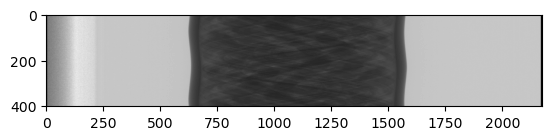

In [9]:
plt.imshow(img[:,1000],cmap='gray')

### Identify the projection blocks per sample rotation

This is done here using the covariance matrix of the sinogram.

The preaks are at  [300]


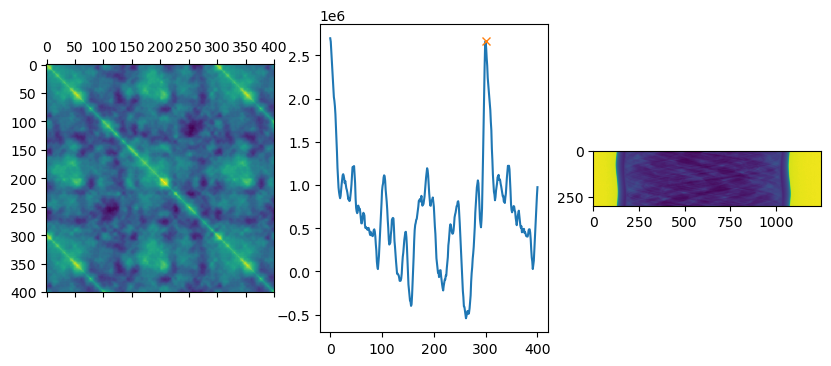

In [12]:
from scipy.signal import find_peaks

c = np.cov(img[:,1000,750:1450])
fig, ax = plt.subplots(1,3,figsize=(10,4))
ax[0].matshow(c)
ax[1].plot(c[0,:])

# Example array
# Find peaks
peaks, _ = find_peaks(c[0,:]*(c[0,:]>2e6))
peaks = np.array(peaks).astype(int)
print("The preaks are at ",peaks)
ax[1].plot(peaks, c[0,peaks], "x")
ax[2].imshow(img[:peaks[0],1000,500:1750])


In [14]:
### Normalize the projections
norm = pm.NormalizeImage(True)
norm.setReferences(ob,dc)
p = norm.process(img[:300])

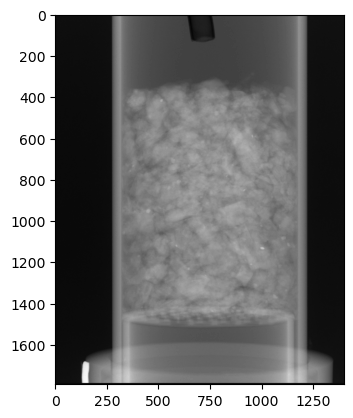

In [15]:
plt.imshow(img[100,:,350:1750],cmap='gray')

### Test reconstruction with the normalized projections

Inner diameter = 29mm
Wall thickness = 1.2mm

In [18]:
help(pm)

Help on package pymuhrec:

NAME
    pymuhrec

PACKAGE CONTENTS
    advfilters
    imgalg
    muhrectomo
    utils (package)

DATA
    BeamGeometryCone = <eBeamGeometry.BeamGeometryCone: 1>
    BeamGeometryHelix = <eBeamGeometry.BeamGeometryHelix: 2>
    BeamGeometryParallel = <eBeamGeometry.BeamGeometryParallel: 0>
    BinDiff_Grad = <eGradientType.BinDiff_Grad: 4>
    Diff_Grad_Minus = <eGradientType.Diff_Grad_Minus: 3>
    FilterDiffusion = <eFilterType.FilterDiffusion: 2>
    FilterGauss = <eFilterType.FilterGauss: 4>
    FilterISS = <eFilterType.FilterISS: 0>
    FilterISSp = <eFilterType.FilterISSp: 1>
    FilterIteratedMedian = <eFilterType.FilterIteratedMedian: 3>
    InitialImageOriginal = <eInitialImageType.InitialImageOriginal: 0>
    InitialImageZero = <eInitialImageType.InitialImageZero: 1>
    Jahne_Grad = <eGradientType.Jahne_Grad: 1>
    MorphCleanFill = <eMorphCleanMethod.MorphCleanFill: 1>
    MorphCleanReplace = <eMorphCleanMethod.MorphCleanReplace: 0>
    MorphDetect

In [22]:
recon = pm.Reconstructor(pm.bpFDKSingle)
#recon = pm.Reconstructor(pm.bpMultiProjParallel)

In [36]:
Nproj = 300
args = {"angles" : np.linspace(0,360,num=Nproj), 
        "weights" : 1.0/np.ones(Nproj)}

# Then
recon.configure({"center" : 50, 
                              "resolution" : 0.139,
                             "sod" : 255,
                             "sdd" : 1055,
                             "piercingpoint" : [1100, 0],
                             "roi" : [450,940,1750, 950]
                             })
recon.process(img[:300,940:950,450:1750],args)
vol = recon.volume()

1300 10 300


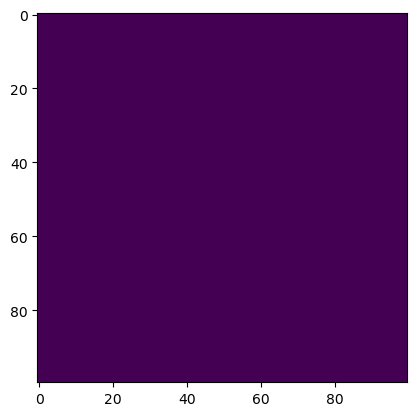

In [38]:
plt.imshow(vol[5,600:700,600:700])

## Set up the optimizer

In [17]:
def reconstruct_slice(SDD, SOD, piercing_point, geometry_params):
    """
    Mock function to reconstruct a slice given the geometry parameters.
    Replace this with actual reconstruction code.
    """
    # Placeholder for reconstruction logic
    # geometry_params should include detector info, pixel pitch, etc.
    reconstructed_slice = np.random.rand(256, 256)  # Dummy 2D image
    return reconstructed_slice

def compute_metrics(reconstructed_slice):
    """
    Compute variance, entropy, total variation, and gradient magnitude.
    """
    # Variance
    variance = np.var(reconstructed_slice)
    
    # Entropy
    # ent = entropy(exposure.rescale_intensity(reconstructed_slice), disk(3))
    # mean_entropy = np.mean(ent)
    
    # Total Variation (TV)
    # tv = denoise_tv_chambolle(reconstructed_slice, weight=0.1, multichannel=False)
    # total_variation = np.sum(np.abs(reconstructed_slice - tv))
    
    # Gradient Magnitude (sharpness)
    gradient_magnitude = np.mean(np.abs(sobel(reconstructed_slice)))
    
    # return variance, mean_entropy, total_variation, gradient_magnitude
    return variance, gradient_magnitude

def cost_function(params, geometry_params):
    """
    Cost function for optimization.
    Combines variance, entropy, total variation, and gradient magnitude with weights.
    """
    SDD, SOD, piercing_point = params
    reconstructed_slice = reconstruct_slice(SDD, SOD, piercing_point, geometry_params)
    # variance, ent, total_variation, gradient_magnitude = compute_metrics(reconstructed_slice)
    variance, gradient_magnitude = compute_metrics(reconstructed_slice)
    
    # Combine metrics into a single cost
    # Adjust weights to emphasize the importance of each metric
    weight_variance = 1.0
    weight_entropy = 1.0
    weight_tv = 0.5
    weight_gradient = 0.5

    cost = (
        - weight_variance * variance  # Maximize variance
        - weight_gradient * gradient_magnitude  # Maximize sharpness
    )
    # cost = (
    #     -weight_variance * variance  # Maximize variance
    #     + weight_entropy * ent       # Minimize entropy
    #     + weight_tv * total_variation  # Minimize total variation (reduce noise)
    #     - weight_gradient * gradient_magnitude  # Maximize sharpness
    # )
    return cost

def optimize_geometry(initial_guess, geometry_params):
    """
    Perform optimization using the conjugate gradient method.
    """
    result = minimize(
        fun=cost_function,
        x0=initial_guess,
        args=(geometry_params,),
        method='CG',
        options={'disp': True}
    )
    return result

# Known inputs
geometry_params = {
    "detector_pixel_pitch": 0.1,  # Example value in mm
    "magnification": 2.0,
    "max_cone_angle": 40,  # degrees
    "max_SDD": 2000.0,  # Example value in mm
    "center_of_rotation": 128.0,  # Example value in pixel units
}

# Initial guesses for SDD, SOD, and piercing_point
initial_guess = [1500.0, 1000.0, 0.0]  # Example initial values

# Run optimization
result = optimize_geometry(initial_guess, geometry_params)

# Optimized parameters
print("Optimized Parameters:")
print("SDD:", result.x[0])
print("SOD:", result.x[1])
print("Vertical Piercing Point:", result.x[2])

         Current function value: -0.195826
         Iterations: 1
         Function evaluations: 90
         Gradient evaluations: 20
Optimized Parameters:
SDD: 1499.9999910272388
SOD: 1000.00001770296
Vertical Piercing Point: 1.111844011758008e-05


/Users/kaestner/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:703: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)
